In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
try:
    import seaborn as sns
except ImportError:
    pass
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('students_simple.csv')
print("Файл успешно подключен")

Файл успешно подключен


In [5]:
N = 11  
col1_idx = N % 5 
col2_idx = (N**2 % 5) + 5  

columns = df.columns
col1 = columns[col1_idx]
col2 = columns[col2_idx]

print(f"Выбранные столбцы:")
print(f"Столбец 1 (N % 5 = {N % 5}): {col1}")
print(f"Столбец 2 (N² % 5 + 5 = {(N**2 % 5) + 5}): {col2}")

# Извлекаем данные
x = df[col1].dropna().values
y = df[col2].dropna().values

min_len = min(len(x), len(y))
x = x[:min_len]
y = y[:min_len]

print(f"\nРазмер выборки: {len(x)}")
print(f"Столбец 1 ({col1}): min={x.min():.3f}, max={x.max():.3f}, mean={x.mean():.3f}")
print(f"Столбец 2 ({col2}): min={y.min():.3f}, max={y.max():.3f}, mean={y.mean():.3f}")

Выбранные столбцы:
Столбец 1 (N % 5 = 1): mass
Столбец 2 (N² % 5 + 5 = 6): bmi

Размер выборки: 20
Столбец 1 (mass): min=45.000, max=95.000, mean=67.450
Столбец 2 (bmi): min=2.011, max=3.533, mean=2.613


In [15]:
def fechner(x: np.ndarray, y: np.ndarray):
    mx, my = x.mean(), y.mean()
    dx, dy = x - mx, y - my

    t = (dx * dy) > 0
    C = np.count_nonzero(t)
    D = np.count_nonzero(~t)

    return (C - D) / (C + D)

def pearson(x: np.ndarray, y: np.ndarray):
    return np.corrcoef(x, y)[0,1].item()

def spearman(x: np.ndarray, y: np.ndarray):
    rx = x.argsort().argsort()
    ry = y.argsort().argsort()
    return pearson(rx, ry)

def kendall(x: np.ndarray, y: np.ndarray):
    rx = x.argsort().argsort()
    ry = y.argsort().argsort()
    r, _ = kendalltau(rx, ry)
    return r.item()

# доверительным интервалом
def pearson_with_ci(x, y, confidence=0.95):
    corr = pearson(x, y)
    z = np.arctanh(corr)
    se = 1 / np.sqrt(len(x) - 3)
    z_crit = stats.norm.ppf((1 + confidence) / 2)
    
    ci_low = np.tanh(z - z_crit * se)
    ci_high = np.tanh(z + z_crit * se)
    
    # p-value для Пирсона
    _, p_value = stats.pearsonr(x, y)
    
    return corr, (ci_low, ci_high), p_value

# Вычисляем все корреляции
fechner_corr = fechner(x, y)
pearson_corr, pearson_ci, pearson_p = pearson_with_ci(x, y)
spearman_corr = spearman(x, y)
kendall_corr = kendall(x, y)

# p-value для Спирмена и Кенделла
_, spearman_p = stats.spearmanr(x, y)
_, kendall_p = stats.kendalltau(x, y)

print("РЕЗУЛЬТАТЫ КОРРЕЛЯЦИОННОГО АНАЛИЗА")
print("=" * 50)
print(f"Корреляция Фехнера: {fechner_corr:.4f}")
print(f"Корреляция Пирсона: {pearson_corr:.4f}")
print(f"Доверительный интервал Пирсона (95%): [{pearson_ci[0]:.4f}, {pearson_ci[1]:.4f}]")
print(f"p-value Пирсона: {pearson_p:.4f}")
print(f"Корреляция Спирмена: {spearman_corr:.4f}")
print(f"p-value Спирмена: {spearman_p:.4f}")
print(f"Корреляция Кенделла: {kendall_corr:.4f}")
print(f"p-value Кенделла: {kendall_p:.4f}")

РЕЗУЛЬТАТЫ КОРРЕЛЯЦИОННОГО АНАЛИЗА
Корреляция Фехнера: -0.9000
Корреляция Пирсона: -0.9606
Доверительный интервал Пирсона (95%): [-0.9846, -0.9012]
p-value Пирсона: 0.0000
Корреляция Спирмена: -0.9789
p-value Спирмена: 0.0000
Корреляция Кенделла: -0.9158
p-value Кенделла: 0.0000


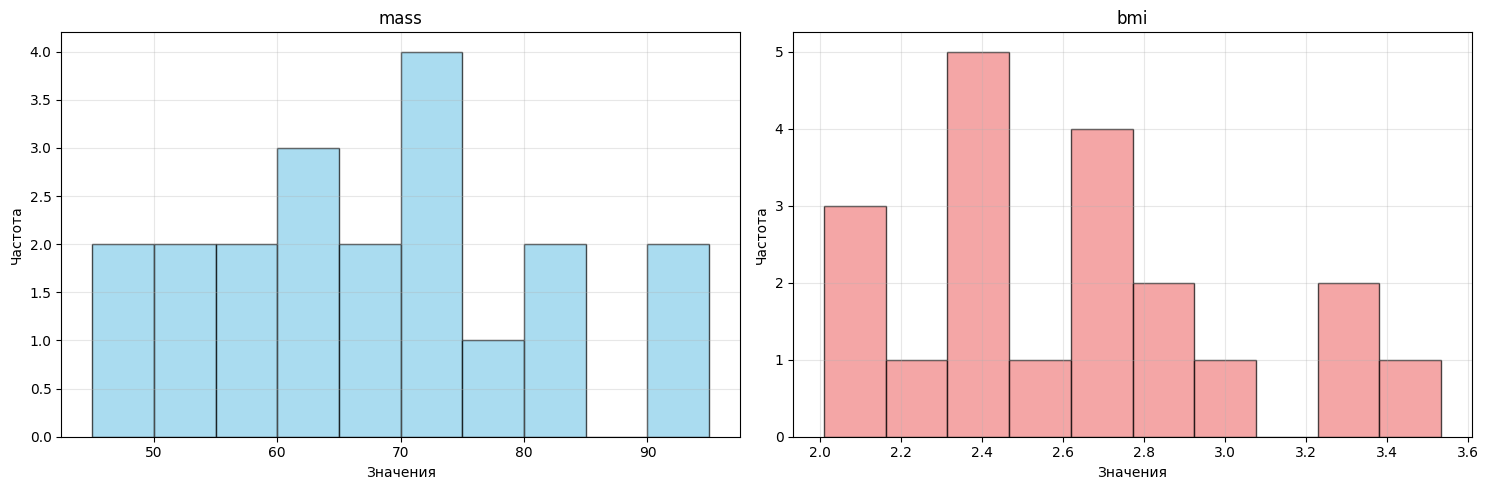

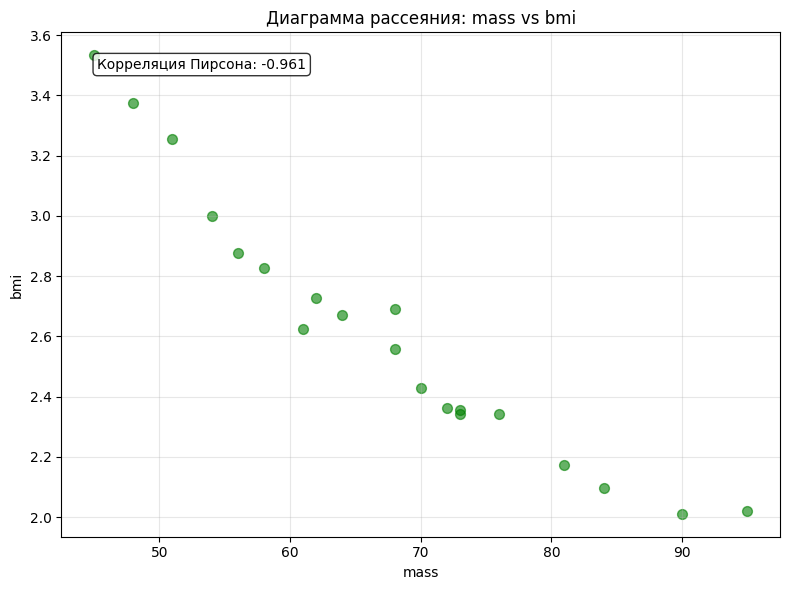

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(x, edgecolor="black", alpha=0.7, color='skyblue')
ax1.set_title(col1)
ax1.set_xlabel('Значения')
ax1.set_ylabel('Частота')
ax1.grid(True, alpha=0.3)

ax2.hist(y, edgecolor="black", alpha=0.7, color='lightcoral')
ax2.set_title(col2)
ax2.set_xlabel('Значения')
ax2.set_ylabel('Частота')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, color='green', s=50)
plt.title(f'Диаграмма рассеяния: {col1} vs {col2}')
plt.xlabel(col1)
plt.ylabel(col2)
plt.grid(True, alpha=0.3)

corr_text = f'Корреляция Пирсона: {pearson_corr:.3f}'
plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

In [ ]:
nx = x.reshape(-1, 1)
nx = (nx - nx.mean()) / nx.std()

# Функция для линейной регрессии через нормальные уравнения
def linear_regression(X, y):
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    coefficients = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    return coefficients[1:], coefficients[0] 

# Линейная регрессия
lin_coef, lin_intercept = linear_regression(nx, y)
lin_pred = lin_coef * nx.flatten() + lin_intercept

# Квадратичная регрессия
X_quad = np.column_stack([nx.flatten(), nx.flatten()**2])
quad_coef, quad_intercept = linear_regression(X_quad, y)
quad_pred = quad_coef[0] * nx.flatten() + quad_coef[1] * nx.flatten()**2 + quad_intercept

# Гиперболическая регрессия
X_hyp = 1 / nx
hyp_coef, hyp_intercept = linear_regression(X_hyp, y)
hyp_pred = hyp_coef / nx.flatten() + hyp_intercept

# ПОКАЗАТЕЛЬНАЯ РЕГРЕССИЯ
exp_coef, exp_intercept = linear_regression(nx, np.log(y))
exp_pred = np.exp(exp_coef * nx.flatten() + exp_intercept)

# Вычисляем R²
results = {
    'linear': {'pred': lin_pred, 'r2': 1 - np.sum((y - lin_pred)**2) / np.sum((y - y.mean())**2)},
    'quadratic': {'pred': quad_pred, 'r2': 1 - np.sum((y - quad_pred)**2) / np.sum((y - y.mean())**2)},
    'hyperbolic': {'pred': hyp_pred, 'r2': 1 - np.sum((y - hyp_pred)**2) / np.sum((y - y.mean())**2)},
    'exponential': {'pred': exp_pred, 'r2': 1 - np.sum((y - exp_pred)**2) / np.sum((y - y.mean())**2)}
}

print("РЕЗУЛЬТАТЫ")
print("=" * 50)
for model, result in results.items():
    print(f"{model.upper():12} | R² = {result['r2']:.4f}")

print(f"\nУравнения регрессии:")
print(f"Линейная: y = {lin_coef[0]:.4f}·x_norm + {lin_intercept:.4f}")
print(f"Квадратичная: y = {quad_coef[1]:.4f}·x_norm² + {quad_coef[0]:.4f}·x_norm + {quad_intercept:.4f}")
print(f"Гиперболическая: y = {hyp_coef[0]:.4f}/x_norm + {hyp_intercept:.4f}")
print(f"Показательная: y = {np.exp(exp_intercept):.4f}·e^({exp_coef[0]:.4f}·x_norm)")

РЕЗУЛЬТАТЫ РЕГРЕССИОННОГО АНАЛИЗА
LINEAR       | R² = 0.9228
QUADRATIC    | R² = 0.9779
HYPERBOLIC   | R² = 0.0136
EXPONENTIAL  | R² = 0.9542

Уравнения регрессии:
Линейная: y = -0.4084·x_norm + 2.6134
Квадратичная: y = 0.0869·x_norm² + -0.4308·x_norm + 2.5264
Гиперболическая: y = -0.0066/x_norm + 2.6305
Показательная: y = 2.5800·e^(-0.1555·x_norm)


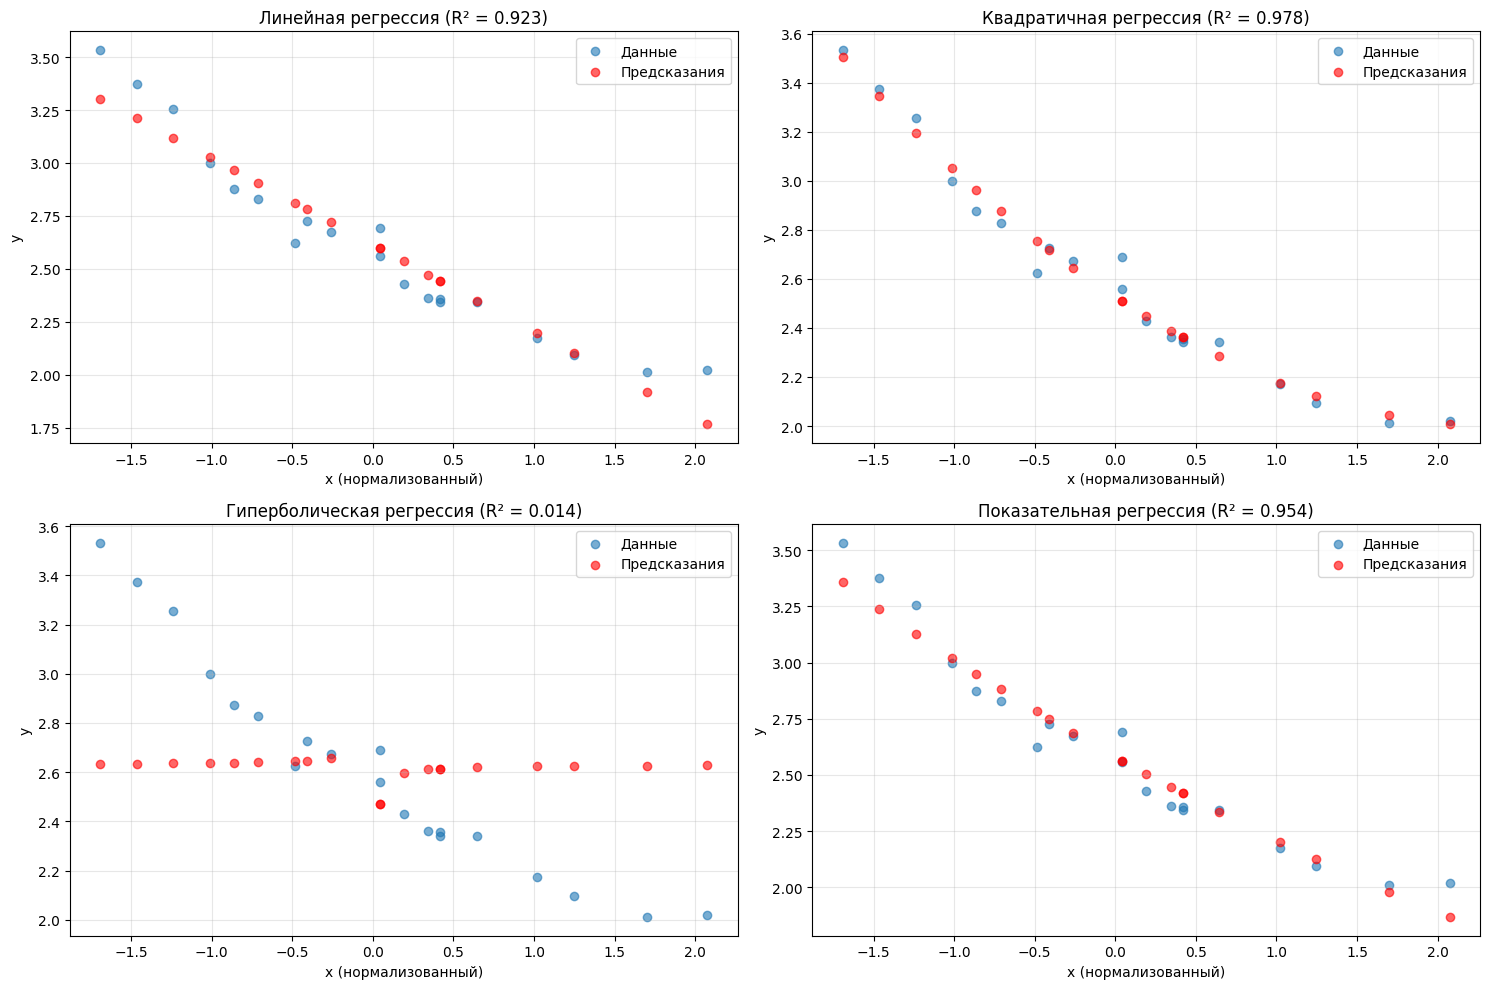

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(nx, y, alpha=0.6, label='Данные')
axes[0, 0].scatter(nx, lin_pred, color='red', alpha=0.6, label='Предсказания')
axes[0, 0].set_title(f'Линейная регрессия (R² = {results["linear"]["r2"]:.3f})')
axes[0, 0].set_xlabel('x (нормализованный)')
axes[0, 0].set_ylabel('y')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(nx, y, alpha=0.6, label='Данные')
axes[0, 1].scatter(nx, quad_pred, color='red', alpha=0.6, label='Предсказания')
axes[0, 1].set_title(f'Квадратичная регрессия (R² = {results["quadratic"]["r2"]:.3f})')
axes[0, 1].set_xlabel('x (нормализованный)')
axes[0, 1].set_ylabel('y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(nx, y, alpha=0.6, label='Данные')
axes[1, 0].scatter(nx, hyp_pred, color='red', alpha=0.6, label='Предсказания')
axes[1, 0].set_title(f'Гиперболическая регрессия (R² = {results["hyperbolic"]["r2"]:.3f})')
axes[1, 0].set_xlabel('x (нормализованный)')
axes[1, 0].set_ylabel('y')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(nx, y, alpha=0.6, label='Данные')
axes[1, 1].scatter(nx, exp_pred, color='red', alpha=0.6, label='Предсказания')
axes[1, 1].set_title(f'Показательная регрессия (R² = {results["exponential"]["r2"]:.3f})')
axes[1, 1].set_xlabel('x (нормализованный)')
axes[1, 1].set_ylabel('y')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def fisher(predict: np.ndarray, target: np.ndarray):
    num = (predict - target).std() ** 2
    den = target.std() ** 2
    return num / den

# критерий Фишера 
fisher_results = {}
for model, result in results.items():
    fisher_results[model] = fisher(result['pred'], y)

print("КРИТЕРИЙ ФИШЕРА ")
print("=" * 50)
for model, f_value in fisher_results.items():
    print(f"{model.upper():12} | F = {f_value:.6f}")

# Находим наилучшую и наихудшую модели по R²
best_model = max(results.items(), key=lambda x: x[1]['r2'])
worst_model = min(results.items(), key=lambda x: x[1]['r2'])

print(f"\nНАИЛУЧШАЯ МОДЕЛЬ ({best_model[0].upper()}):")
print(f"  R² = {best_model[1]['r2']:.4f}")
print(f"  F = {fisher_results[best_model[0]]:.6f}")

print(f"\nНАИХУДШАЯ МОДЕЛЬ ({worst_model[0].upper()}):")
print(f"  R² = {worst_model[1]['r2']:.4f}")
print(f"  F = {fisher_results[worst_model[0]]:.6f}")

КРИТЕРИЙ ФИШЕРА 
LINEAR       | F = 0.077229
QUADRATIC    | F = 0.022070
HYPERBOLIC   | F = 0.986423
EXPONENTIAL  | F = 0.045729

НАИЛУЧШАЯ МОДЕЛЬ (QUADRATIC):
  R² = 0.9779
  F = 0.022070

НАИХУДШАЯ МОДЕЛЬ (HYPERBOLIC):
  R² = 0.0136
  F = 0.986423
